# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir
import random
path = '/datasets/faces/'

In [2]:
labels_df = pd.read_csv(path+'labels.csv')
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В выборке 7591 изображение. Нельзя сказать точно, что данных не достаточно. Может и хватить. В случае переобучения модели будем бороться с этим различными способами, в том числе за счет увеличения количества данных с помощью аугментации. 

В данных нет пропусков, можно приступать к исследованию.

In [4]:
labels_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Диапазон возраста соответствует естественным границам, аномальные значения отсутствуют. Медиана смещена влево относительно среднего, то есть в датасете больше фотографий молодых людей (половина до 20 лет включительно).

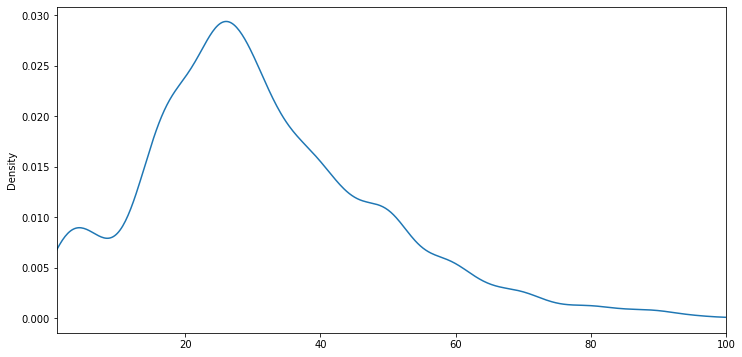

In [5]:
labels_df['real_age'].plot(kind='kde', 
                           figsize=(12,6), 
                           xlim=(labels_df['real_age'].min(), 
                                 labels_df['real_age'].max()))
None

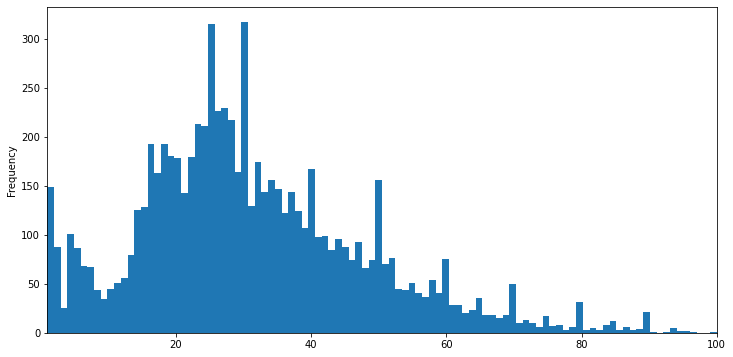

In [10]:
labels_df['real_age'].plot(kind='hist', bins=100,
                           figsize=(12,6), 
                           xlim=(labels_df['real_age'].min(), 
                                 labels_df['real_age'].max()))
None

Присутствуют явные пики на "круглых" возрастах начиная с 30: 30, 40, 50, 60, 70, 80, 90 лет. Возможно, разметку датасета проводили эксперты (людям свойственно приводить возраст к ровным значениям).

In [21]:
labels_df['real_age'].value_counts().sort_values(ascending=False).head()

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

In [23]:
pop_age = labels_df['real_age'].value_counts().sort_values(ascending=False).head(2).sum() / len(labels_df['real_age'])
print(f'Два самых популярных возраста 25 и 30 лет. Они составляют {pop_age:.1%} от всех данных.')

Два самых популярных возраста 25 и 30 лет. Они составляют 8.3% от всех данных.


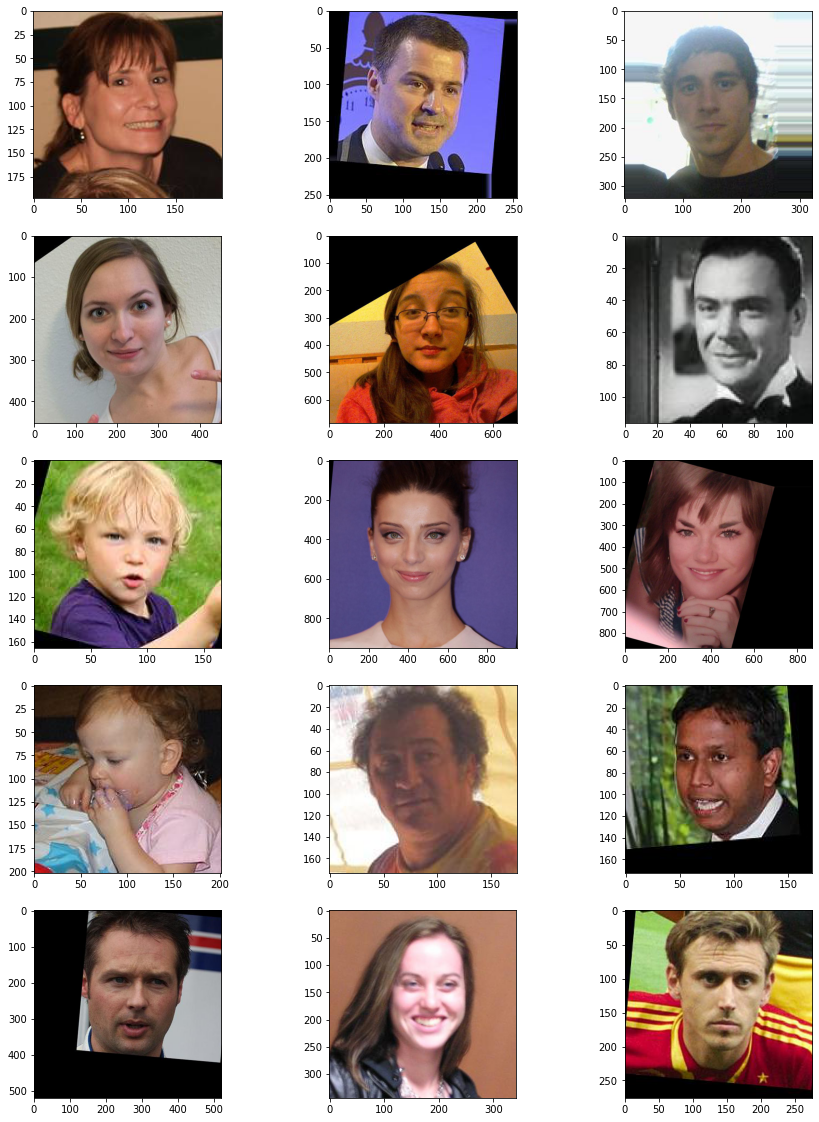

In [7]:
files_list = listdir(path+'final_files/')
random_files = random.sample(files_list, 15)

fig = plt.figure(figsize=(15, 20))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    image = Image.open(path+'final_files/'+random_files[i-1])
    plt.imshow(image)
plt.show()

***Выводы:*** 

* количество данных может не хватить для обучения модели. В случае переобучения будем использовать в том числе аугментацию.
* аномальные значения в целевом признаке отсуствуют, можно использовать для обучения модели.
* график плотности распределения свидетельствует, что в датасете присутствует большое количество фотографий молодых людей в том числе детей до 10 лет.
* на круглых возрастах присуствуют пики.
* два самых популярных возраста - 25 и 30 лет - состваляют более 8% данных.
* изображения разного разрешения - будем приводить к одному размеру.
* часть изображений повернуты. Если не будет хватать данных, будем аугментировать датасет путем поворта изображений на небольшой угол (допустим, на 10 градусов).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_train(path):
    labels = pd.read_csv(path+'/labels.csv')
    print(labels.head())
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    #print(len(test_datagen_flow))
    return test_datagen_flow
        
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(15, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    model.summary()
    return model

def train_model(model, train_data, test_data, batch_size= None, epochs=5,
               steps_per_epoch=None, validation_steps=None): 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
2022-06-22 04:10:10.735803: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-22 04:10:10.737475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2022-06-22 04:10:11.956200: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-22 04:10:12.624350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-22 04:10:12.624441: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-22 04:10:12.624474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-22 04:10:12.626381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-22 04:10:12.626809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-22 04:10:12.628998: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-22 04:10:12.630130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-22 04:10:12.630195: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-22 04:10:12.634511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-22 04:10:12.634897: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-22 04:10:12.641795: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-22 04:10:12.642265: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4780e00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-22 04:10:12.642290: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-22 04:10:12.782573: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3d63ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-22 04:10:12.782614: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-22 04:10:12.785057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-22 04:10:12.785120: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-22 04:10:12.785130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-22 04:10:12.785159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-22 04:10:12.785169: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-22 04:10:12.785179: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-22 04:10:12.785188: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-22 04:10:12.785196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-22 04:10:12.789634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-22 04:10:12.789694: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-22 04:10:13.093290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-22 04:10:13.093345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-22 04:10:13.093354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-22 04:10:13.098078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                61470     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
=================================================================
Total params: 23,649,663
Trainable params: 23,596,543
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/5
2022-06-22 04:10:23.713605: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-22 04:10:23.997790: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 44s - loss: 430.0837 - mae: 15.8117 - val_loss: 765.5653 - val_mae: 22.5827
Epoch 2/5
190/190 - 37s - loss: 237.3260 - mae: 11.5658 - val_loss: 405.8817 - val_mae: 14.9761
Epoch 3/5
190/190 - 37s - loss: 210.7981 - mae: 10.8439 - val_loss: 319.4823 - val_mae: 12.9583
Epoch 4/5
190/190 - 37s - loss: 189.3210 - mae: 10.2603 - val_loss: 181.5375 - val_mae: 10.1314
Epoch 5/5
190/190 - 37s - loss: 179.7746 - mae: 9.9511 - val_loss: 86.8296 - val_mae: 7.1462
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 86.8296 - mae: 7.1462
Test MAE: 7.1462
```

## Анализ обученной модели

***Вывод:*** В результате работы моделей была получена средняя абсолютная ошибка ниже требуемой. Точность подели еще можно увеличивать за счет полносвязной части, увеличивая количество слоев и нейронов, а также эпох обучения. Также можно увеличивать количество эпох - до переобучения скорее всего еще далеко. Аугментация не потребовалась, переобучения удалось избежать с помощью dropout.